### Load Dataset

In [9]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
from tensorflow import keras


# Set seed
tf.random.set_seed(42)

# Load MNIST data
(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype("float32") / 255.
x_test = x_test.astype("float32") / 255.
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

input_shape = (28, 28, 1)
latent_dim = 2


### Encoder & Decoder Architecture

In [4]:
def build_encoder(input_shape, latent_dim):
    encoder_inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
    x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
    x = layers.Flatten()(x)
    x = layers.Dense(16, activation="relu")(x)
    z_mean = layers.Dense(latent_dim, name="z_mean")(x)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)

    # Sampling function
    def sampling(args):
        z_mean, z_log_var = args
        epsilon = tf.random.normal(shape=(tf.shape(z_mean)[0], latent_dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

    z = layers.Lambda(sampling, name="z")([z_mean, z_log_var])
    encoder = Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
    return encoder

def build_decoder(latent_dim):
    latent_inputs = layers.Input(shape=(latent_dim,))
    x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
    x = layers.Reshape((7, 7, 64))(x)
    x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
    x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
    decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
    decoder = Model(latent_inputs, decoder_outputs, name="decoder")
    return decoder


### VAE with BCE or MSE Loss

In [11]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, loss_type='bce', **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.loss_type = loss_type
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        return self.decoder(z)

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)

            if self.loss_type == 'bce':
                reconstruction_loss = tf.reduce_mean(
                    tf.reduce_sum(
                        keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                    )
                )
            elif self.loss_type == 'mse':
                reconstruction_loss = tf.reduce_mean(
                    tf.reduce_sum(tf.square(data - reconstruction), axis=(1, 2, 3))
                )
            else:
                raise ValueError("Unsupported loss type")

            kl_loss = -0.5 * tf.reduce_mean(
                tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
            )
            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def test_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        z_mean, z_log_var, z = self.encoder(data)
        reconstruction = self.decoder(z)

        if self.loss_type == 'bce':
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
        elif self.loss_type == 'mse':
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(tf.square(data - reconstruction), axis=(1, 2, 3))
            )
        kl_loss = -0.5 * tf.reduce_mean(
            tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
        )
        total_loss = reconstruction_loss + kl_loss

        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }


In [12]:
# Common encoder/decoder
encoder = build_encoder(input_shape, latent_dim)
decoder = build_decoder(latent_dim)

# VAE with BCE
vae_bce = VAE(encoder, decoder, loss_type='bce')
vae_bce.compile(optimizer=tf.keras.optimizers.Adam())
history_bce = vae_bce.fit(x_train, epochs=10, batch_size=128, validation_data=(x_test, None))

# Re-initialize encoder/decoder for MSE model
encoder_mse = build_encoder(input_shape, latent_dim)
decoder_mse = build_decoder(latent_dim)

# VAE with MSE
vae_mse = VAE(encoder_mse, decoder_mse, loss_type='mse')
vae_mse.compile(optimizer=tf.keras.optimizers.Adam())
history_mse = vae_mse.fit(x_train, epochs=10, batch_size=128, validation_data=(x_test, None))


Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - kl_loss: 2.1682 - loss: 269.1534 - reconstruction_loss: 266.9851 - val_kl_loss: 3.3665 - val_loss: 195.6380 - val_reconstruction_loss: 192.2715
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - kl_loss: 3.3151 - loss: 189.8964 - reconstruction_loss: 186.5813 - val_kl_loss: 5.1287 - val_loss: 177.2442 - val_reconstruction_loss: 172.1155
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - kl_loss: 5.7047 - loss: 172.8465 - reconstruction_loss: 167.1418 - val_kl_loss: 5.2821 - val_loss: 166.7055 - val_reconstruction_loss: 161.4234
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - kl_loss: 5.9680 - loss: 165.8555 - reconstruction_loss: 159.8875 - val_kl_loss: 5.7076 - val_loss: 160.8106 - val_reconstruction_loss: 155.1030
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - kl_loss: 6.1668 - loss: 162.3368 - reconstruction_loss: 156.1701 - val_kl_loss: 5.8281 - val_loss: 158.0699 - val_reconstruction_loss: 152.2417


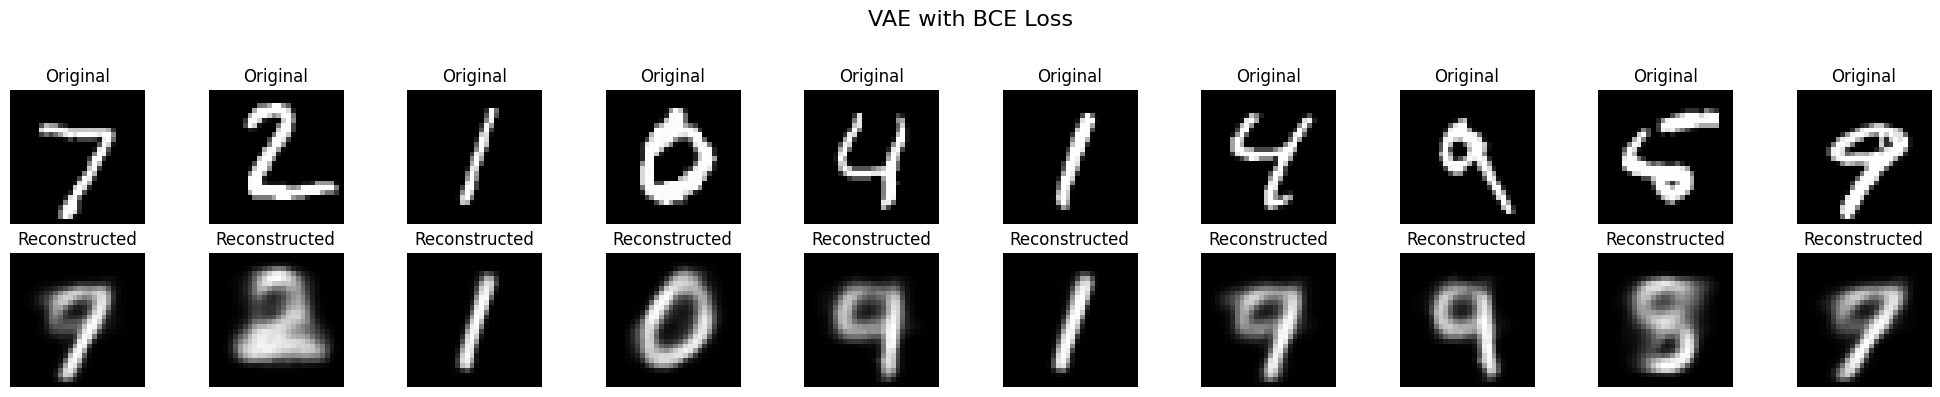

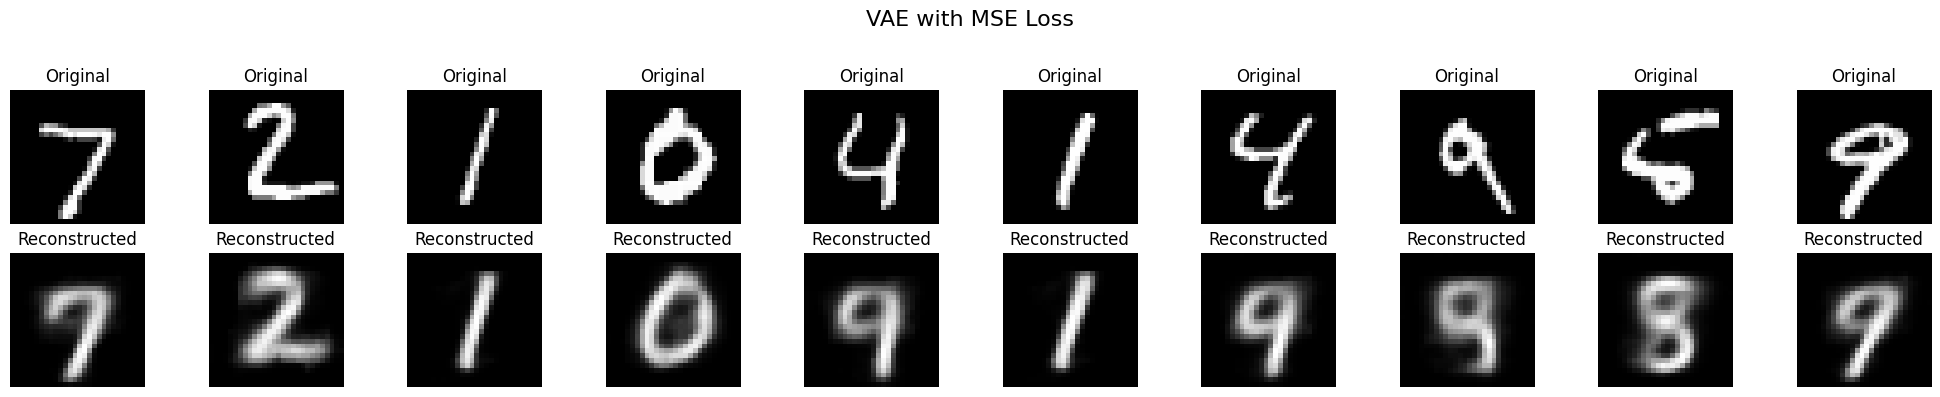

In [ ]:
import matplotlib.pyplot as plt

def show_reconstruction(model, data, title, n=10):
    decoded_imgs = model.decoder(model.encoder(data[:n])[2])
    
    plt.figure(figsize=(20, 4))
    plt.suptitle(title, fontsize=16)  
    
    for i in range(n):
        # Original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(data[i].squeeze(), cmap="gray")
        plt.title("Original")
        plt.axis("off")
        
        # Reconstructed
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(decoded_imgs[i].numpy().squeeze(), cmap="gray")
        plt.title("Reconstructed")
        plt.axis("off")
    
    plt.tight_layout(rect=[0, 0, 1, 0.95]) 
    plt.show()

# Show reconstructions from both models
show_reconstruction(vae_bce, x_test, title="VAE with BCE Loss")
show_reconstruction(vae_mse, x_test, title="VAE with MSE Loss")


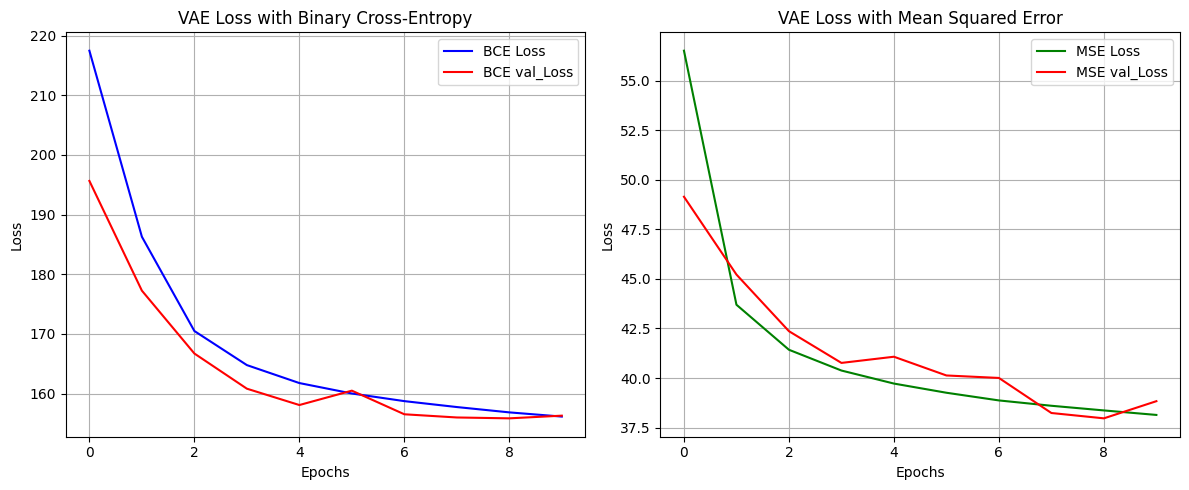

In [21]:
import matplotlib.pyplot as plt

def plot_loss_comparison(history_bce, history_mse):
    plt.figure(figsize=(12, 5))

    # BCE subplot
    plt.subplot(1, 2, 1)
    plt.plot(history_bce.history['loss'], label='BCE Loss', color='blue')
    plt.plot(history_bce.history['val_loss'], label='BCE val_Loss', color='red')
    plt.title("VAE Loss with Binary Cross-Entropy")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.legend()

    # MSE subplot
    plt.subplot(1, 2, 2)
    plt.plot(history_mse.history['loss'], label='MSE Loss', color='green')
    plt.plot(history_mse.history['val_loss'], label='MSE val_Loss', color='red')
    plt.title("VAE Loss with Mean Squared Error")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call the function with histories
plot_loss_comparison(history_bce, history_mse)
